In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from NMF import *
from Audio import *
import utils
import IPython
from data import * 
import soundfile as sf

n_fft = 512
win_length = 512
hop_length = 256
samplerate = 16000
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


Audio Experiment
---

We test standard NMF and ANMF in the semi-supervised case where we only have access to clean and noisy data, but no joint information.
We use a single id from the librispeech dataset, which consists of about 8 minutes of speech. We split this into train and test sets that contain 4 minutes of speech each. We mix the test set with noise from the WHAM! dataset. We rerun the experiment for different input SNR values.

In order to repclicate:
1. Download WHAM! noise dataset (https://wham.whisper.ai/), and put the folder in the same folder as this notebook 
2. Download the clean development set of LibriSpeech (https://www.openslr.org/12), and put the folder in the same folder as this notebook named "Audio".
3. Loading of data is handled by data.py, so if something does not work, check this file.

For parameters we use $512$ samples for the FFT in the STFT.
We further use a hop length of $256$, which corresponds to $50 \%$ overlapping
samples in each window, and we use a Hann window function.
This means that the number of frequency bins is equal to $M = 257$. 
It is possible that increasing the frequency resolution leads to better separation results. 
However, we want a window length with low latency so that it is possible to perform on-line denoising with 
the trained bases.

We select sparsity parameters as small as possible, as selecting them any larger yields poor performance for all methods, as we are not in a setting where sparsity is necessary.

In [2]:
np.random.seed(0)
speaker_list = ["84", "174", "251", "422", "652", "777", "1272", "1673", "1919", "1988", "1993", "2035", "2078", "2277", "2412", "2428", "2803", "2902", "3000", "3081", "3170", "3536", "3576", "3752", "3853", "5338", "5536", "5694", "5895", "6241", "6295", "6313", "6319", "6345", "7850", "7976", "8297", "8842"]

In [3]:

mu_W = 1e-10; 
tau_A = 1.0
epochs = 100
test_epochs = 100
input_snrs = [3]
mu_Hs = [[1e-3,1e-10]]
ds = [128,32]


probs = ["semi", "semi_adv"]
results = {}
results["id"] = []
results["snr"] = []
results["mu_H"] = []
for prob in probs:
    results[prob] = []

mean_snrs = []
mean_sdrs = []


for i,speaker in enumerate(speaker_list):

    seps = []
    audio_data = audio(ids = [speaker])
    results["id"].append(speaker)

    for snr in input_snrs:
        beta = audio_data.generate(snr = snr, seed = i)
        speech_train = audio_data.speech_train
        speech_test = audio_data.speech_test
        noisy_test = audio_data.noisy_test
        noise_test = audio_data.noise_test
        results["snr"].append(snr)
        for j, data in enumerate(noisy_test):
            sf.write('Audio/Result/noisy/'+speaker +'-'+ str(snr) + '-'+str(j) + '.wav', noisy_test[j], samplerate = 16000)

        for mu_H in mu_Hs:
            results["mu_H"].append(mu_H)
            for prob in probs:
                print(f"Running Experiment: Id = {speaker}, SNR = {snr}, mu_H = {mu_H}, prob = {prob}")
                np.random.seed(0)
                sep = audio_separation(ds = ds, prob = prob, tau_A = tau_A, epochs = epochs,
                    test_epochs = test_epochs, mu_W = mu_W, mu_H = mu_H, n_fft = n_fft, hop_length=hop_length, win_length = win_length)
                sep.fit(u = speech_train, v = noisy_test)

                out = sep.separate(noisy_test) 

                sdrs = sep.eval(speech_test, noisy_test, out = out, metric = "SDR")
                for j, data in enumerate(out):
                    sf.write('Audio/Result/out/'+speaker + prob +'-'+str(j)+'-'+ '{:.4g}'.format(sdrs[j]) + '.wav', out[j], samplerate = 16000)

                seps.append(sep) 

                results[prob].append(np.mean(sdrs))#sep.eval(speech_test, noisy_test, out = out, metric = "SDR", aggregate = "mean"))
                print(f"Mean SI-SDR: {np.mean(sdrs)}")

Running Experiment: Id = 84, SNR = 3, mu_H = [0.001, 1e-10], prob = semi
Mean SI-SDR: 6.245639592184473
Running Experiment: Id = 84, SNR = 3, mu_H = [0.001, 1e-10], prob = semi_adv


In [5]:
df = pd.DataFrame(results)
df.to_csv('csv/audio_new.csv', index=False)

In [6]:
import seaborn # For nice plots
df = pd.read_csv('csv/audio_new.csv', index_col = 0)
print(df)


      snr            mu_H      semi   semi_adv
id                                            
84      3  [0.001, 1e-10]  6.245640   6.461106
174     3  [0.001, 1e-10]  4.559430   4.525960
251     3  [0.001, 1e-10]  5.598745   6.755656
422     3  [0.001, 1e-10]  5.447211   5.673592
652     3  [0.001, 1e-10]  4.986064   5.863491
777     3  [0.001, 1e-10]  6.156787   6.314851
1272    3  [0.001, 1e-10]  6.009674   7.677651
1673    3  [0.001, 1e-10]  6.153023   8.657498
1919    3  [0.001, 1e-10]  3.340473   6.094760
1988    3  [0.001, 1e-10]  4.622967   5.463981
1993    3  [0.001, 1e-10]  6.949956   9.458950
2035    3  [0.001, 1e-10]  4.486256   5.749778
2078    3  [0.001, 1e-10]  5.652894   7.321170
2277    3  [0.001, 1e-10]  6.563602   7.663768
2412    3  [0.001, 1e-10]  4.702318   7.317352
2428    3  [0.001, 1e-10]  5.414083   6.179267
2803    3  [0.001, 1e-10]  6.157985   7.519319
2902    3  [0.001, 1e-10]  6.233522   9.323845
3000    3  [0.001, 1e-10]  8.558339   8.014116
3081    3  [0

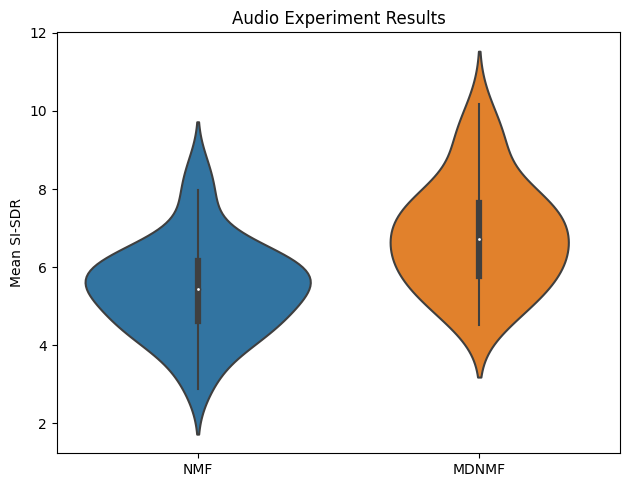

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'column1' and 'column2' with the actual column names in your DataFrame
# Rename the columns for the plot
df_plot = df[['semi', 'semi_adv']].rename(columns={'semi': 'NMF', 'semi_adv': 'MDNMF'})

# Create a boxplot
sns.violinplot(data=df_plot)
plt.ylabel("Mean SI-SDR")

# Display the plot
plt.tight_layout()
plt.title("Audio Experiment Results")
plt.savefig('Audio_result.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [17]:
speech_train = audio_data.speech_train
speech_test = audio_data.speech_test
noisy_test = audio_data.noisy_test
noise_test = audio_data.noise_test

In [18]:
from copy import deepcopy
sep_std = deepcopy(seps[0]) # std separation trained with snr = 0
sep_adv = deepcopy(seps[1]) # adv separation trained with snr = 0

print(sep_std.prob)
print(sep_adv.prob)

semi
semi_adv


In [19]:
sep_std.project = False
sep_adv.project = False

out_std = sep_std.separate(noisy_test)
out_adv = sep_adv.separate(noisy_test)

In [20]:
# Recalculate the SDR of all data

SDR_std = []
SDR_adv = []
SDR_noise = []
PESQ_std = []
PESQ_adv = []
PESQ_noise = []

for i in range(len(out_std)):
    SDR_std.append(calculate_sdr(speech_test[i], out_std[i]))
    SDR_adv.append(calculate_sdr(speech_test[i], out_adv[i]))
    SDR_noise.append(calculate_sdr(speech_test[i], noisy_test[i]))
    #PESQ_std.append(pesq(16000, speech_test[i], out_std[i], 'wb'))
    #PESQ_adv.append(pesq(16000, speech_test[i], out_adv[i], 'wb'))
    #PESQ_noise.append(pesq(16000, speech_test[i], noisy_test[i], 'wb'))

#print(np.mean(PESQ_std))
#print(np.mean(PESQ_adv))
#print(np.mean(PESQ_noise))


In [21]:
# Check how much ANMF outperforms NMF

ids = np.argsort(np.array(SDR_adv) - np.array(SDR_std))
diff = np.sort(np.array(SDR_adv) - np.array(SDR_std))

In [22]:
print(diff)
print(ids)
print(np.mean(SDR_adv))

[-1.65930952 -0.77716205 -0.43271885  0.16034477  0.49396147  0.50559116
  0.90742342  0.99524456  1.53285855  1.58562899  1.7004318   1.82889889
  2.00244652  2.08472601  2.31723797  2.4058921   2.53714311  2.67886644
  2.79663458  3.11452845  5.64705569]
[ 1 16  8  7 18 13  4  5 10 11 20  9 19 17 14  2  3  6 15  0 12]
8.227836898805792


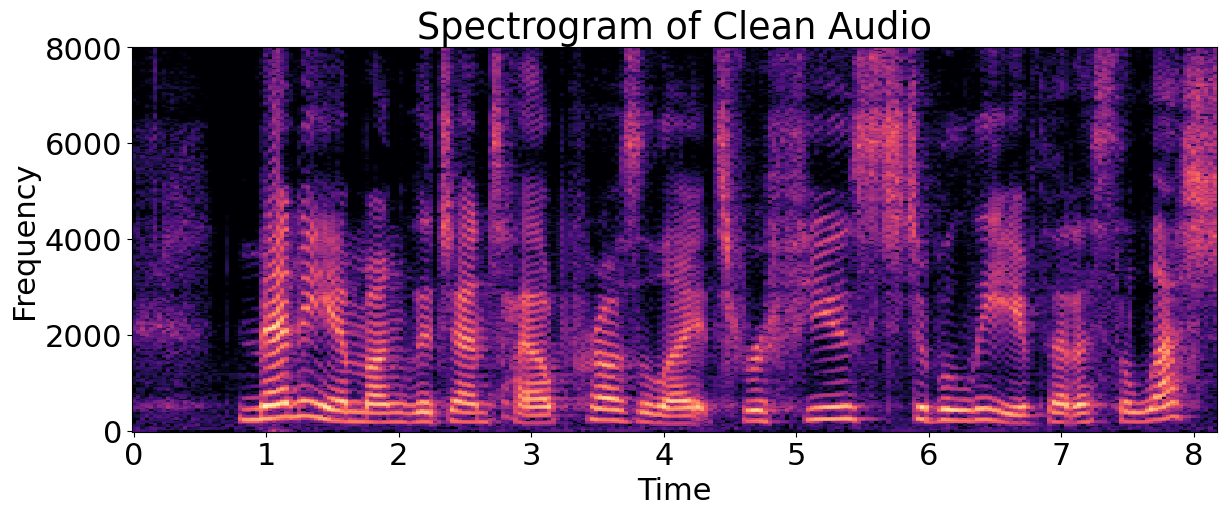

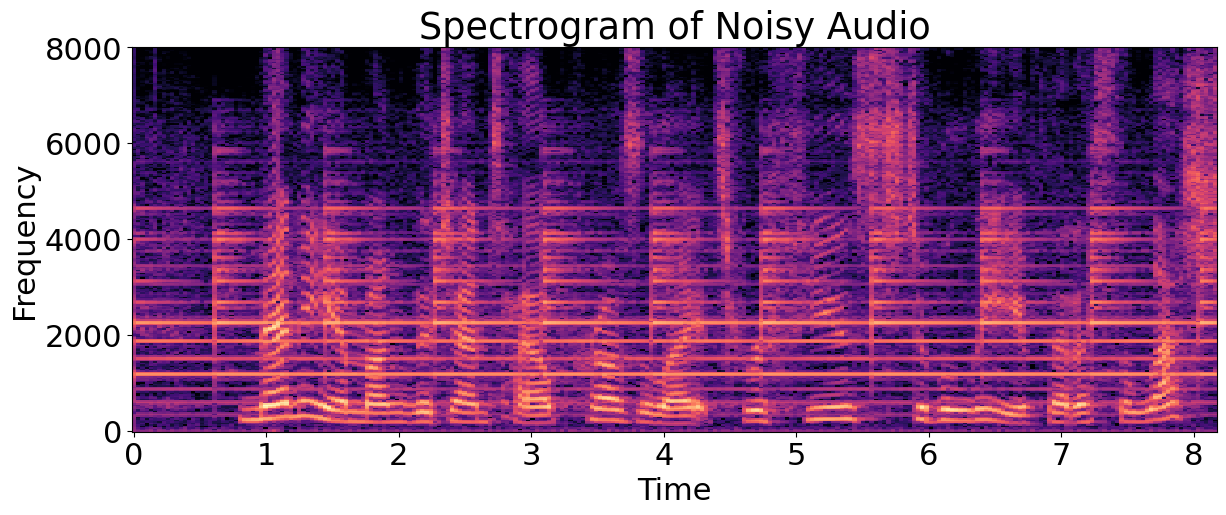

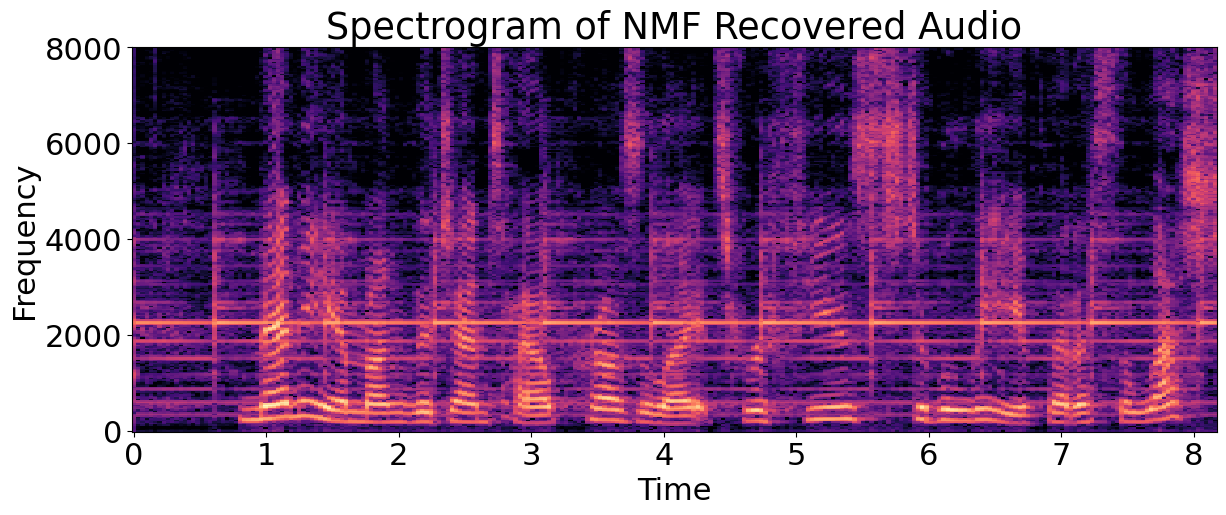

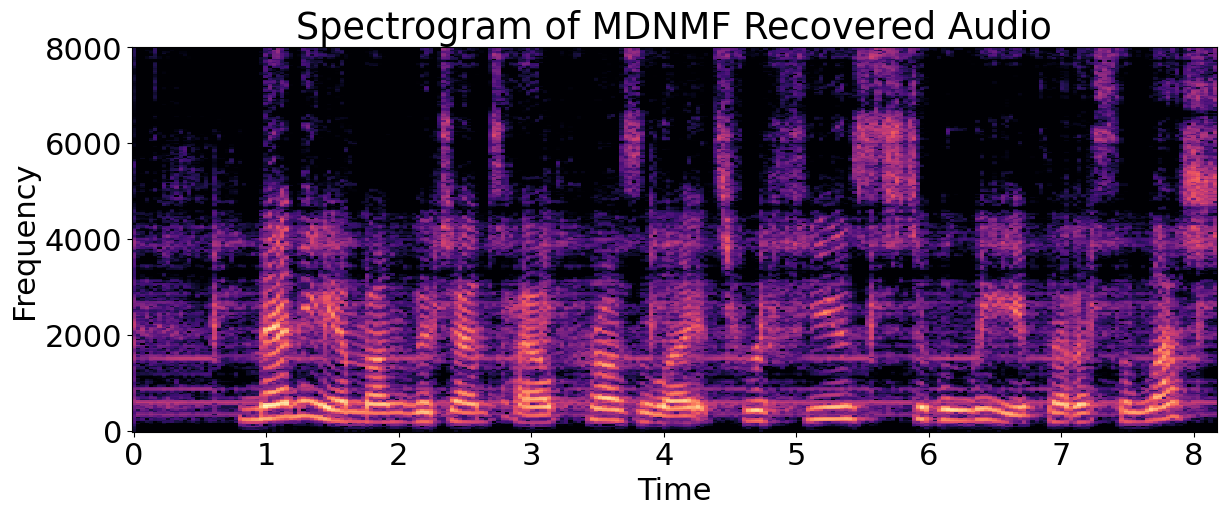

In [23]:
id = 12
plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update({'font.size': 22})

D_clean = librosa.stft(speech_test[id], n_fft = 512, win_length = 512, hop_length = 256)

D_clean_db= librosa.amplitude_to_db(np.abs(D_clean), ref=np.max)

# Plot the STFT
plt.figure(figsize=(14, 5))
librosa.display.specshow(D_clean_db[:,:256], sr=samplerate, x_axis='time', y_axis='linear')
#plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Clean Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.savefig('cleanaudio.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

D_clean = librosa.stft(noisy_test[id], n_fft = 512, win_length = 512, hop_length = 256)

D_clean_db= librosa.amplitude_to_db(np.abs(D_clean), ref=np.max)

# Plot the STFT
plt.figure(figsize=(14, 5))
librosa.display.specshow(D_clean_db[:,:256], sr=samplerate, x_axis='time', y_axis='linear')
#plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Noisy Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.savefig('noisyaudio.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

D_clean = librosa.stft(out_std[id], n_fft = 512, win_length = 512, hop_length = 256)

D_clean_db= librosa.amplitude_to_db(np.abs(D_clean), ref=np.max)

# Plot the STFT
plt.figure(figsize=(14, 5))
librosa.display.specshow(D_clean_db[:,:256], sr=samplerate, x_axis='time', y_axis='linear')
#plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of NMF Recovered Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.savefig('NMFaudio.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

D_clean = librosa.stft(out_adv[id], n_fft = 512, win_length = 512, hop_length = 256)

D_clean_db= librosa.amplitude_to_db(np.abs(D_clean), ref=np.max)

# Plot the STFT
plt.figure(figsize=(14, 5))
librosa.display.specshow(D_clean_db[:,:256], sr=samplerate, x_axis='time', y_axis='linear')
#plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of MDNMF Recovered Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.savefig('ANMFaudio.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [159]:
# Listen to speech, noise and noisy
id = 16

print("CLEAN")
IPython.display.display(IPython.display.Audio(speech_test[id], rate = samplerate))
print("NOISE")
IPython.display.display(IPython.display.Audio(noise_test[id], rate = samplerate))
print("NOISY SPEECH")
IPython.display.display(IPython.display.Audio(noisy_test[id], rate = samplerate))
print("STD DENOISE")
IPython.display.display(IPython.display.Audio(out_std[id], rate = samplerate))
print("ADV DENOISE")
IPython.display.display(IPython.display.Audio(out_adv[id], rate = samplerate))

CLEAN


NOISE


NOISY SPEECH


STD DENOISE


ADV DENOISE
